# CITE-seq data of PBMCs from healthy donors and COVID-19 patients

In this notebook, we examine the CITE-seq data from [Stephenson et al. (Nature Medicine, 2021)](https://www.nature.com/articles/s41591-021-01329-2). The dataset is comprised of PBMC data from healthy donors, COVID-19 patients, non-COVID-19 patients and LPS stimulated cells. 

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mudata as md
#import muon as mu
import scvi

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.4.4 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


## Set paths

In [3]:
file_path = '/home/marenbuettner/development/citeseq_integration/' 
#this is my file path please adapt it to your directory

The data directory contains all processed data and `anndata` files. 

In [4]:
data_dir = file_path + 'data/' 

Raw data path is the directory of the primary data, which are used in the project. 

In [5]:
data_raw_dir = '/home/marenbuettner/public_data/covid_citeseq_stephenson2021/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [6]:
sc.settings.figdir = file_path + 'figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [7]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

## Read data

The full dataset has a size of about 6.7 GB, so loading the data takes a while.   

In [8]:
adata = sc.read(data_raw_dir + 'haniffa21.processed.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 647366 × 24929
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
    var: 'feature_types'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'raw'

In the metadata of the dataset, we have the sample ID (which corresponds to the patient ID), two types of cell type annotation (initial clustering and full clustering). Disease status is covered by Status and Worst clinical status. 

In [10]:
adata.obs[['sample_id', 'Status']].value_counts()

sample_id  Status 
MH9143427  Covid      14317
AP6        Covid      14086
MH8919333  Healthy    12081
MH9143277  Covid      11710
AP11       Covid      10921
                      ...  
MH8919233  LPS          307
MH8919229  LPS          305
MH8919232  LPS          184
MH8919228  LPS          147
MH8919277  LPS           65
Length: 143, dtype: int64

In [11]:
adata.var['feature_types'].value_counts()

Gene Expression     24737
Antibody Capture      192
Name: feature_types, dtype: int64

In [12]:
adata.obs.head().T

covid_index                      AAACCTGAGAAACCTA-MH9179824  \
sample_id                                         MH9179824   
n_genes                                                1160   
n_genes_by_counts                                      1160   
total_counts                                         2172.0   
total_counts_mt                                        79.0   
pct_counts_mt                                      3.637201   
full_clustering                                      CD8.TE   
initial_clustering                                      CD8   
Resample                                            Initial   
Collection_Day                                           D0   
Sex                                                  Female   
Age_interval                                       (50, 59]   
Swab_result                                        Positive   
Status                                                Covid   
Smoker                                           Non-smoker   
Status_on_day_collection                            Ward_O2   
Status_on_day_collection_summary                   Moderate   
Days_from_onset                                           8   
Site                                                    Ncl   
time_after_LPS                                          nan   
Worst_Clinical_Status                              Moderate   
Outcome                                                Home   
patient_id                                        MH9179824   

covid_index                      AAACCTGAGAGTAATC-MH9179824  \
sample_id                                         MH9179824   
n_genes                                                1419   
n_genes_by_counts                                      1419   
total_counts                                         3947.0   
total_counts_mt                                        54.0   
pct_counts_mt                                      1.368128   
full_clustering                                    CD4.IL22   
initial_clustering                                      CD4   
Resample                                            Initial   
Collection_Day                                           D0   
Sex                                                  Female   
Age_interval                                       (50, 59]   
Swab_result                                        Positive   
Status                                                Covid   
Smoker                                           Non-smoker   
Status_on_day_collection                            Ward_O2   
Status_on_day_collection_summary                   Moderate   
Days_from_onset                                           8   
Site                                                    Ncl   
time_after_LPS                                          nan   
Worst_Clinical_Status                              Moderate   
Outcome                                                Home   
patient_id                                        MH9179824   

covid_index                      AAACCTGAGAGTGAGA-MH9179824  \
sample_id                                         MH9179824   
n_genes                                                1986   
n_genes_by_counts                                      1986   
total_counts                                         5886.0   
total_counts_mt                                       143.0   
pct_counts_mt                                      2.429494   
full_clustering                                   CD8.Naive   
initial_clustering                                      CD4   
Resample                                            Initial   
Collection_Day                                           D0   
Sex                                                  Female   
Age_interval                                       (50, 59]   
Swab_result                                        Positive   
Status                                                Covid   
Smoker                       

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tool

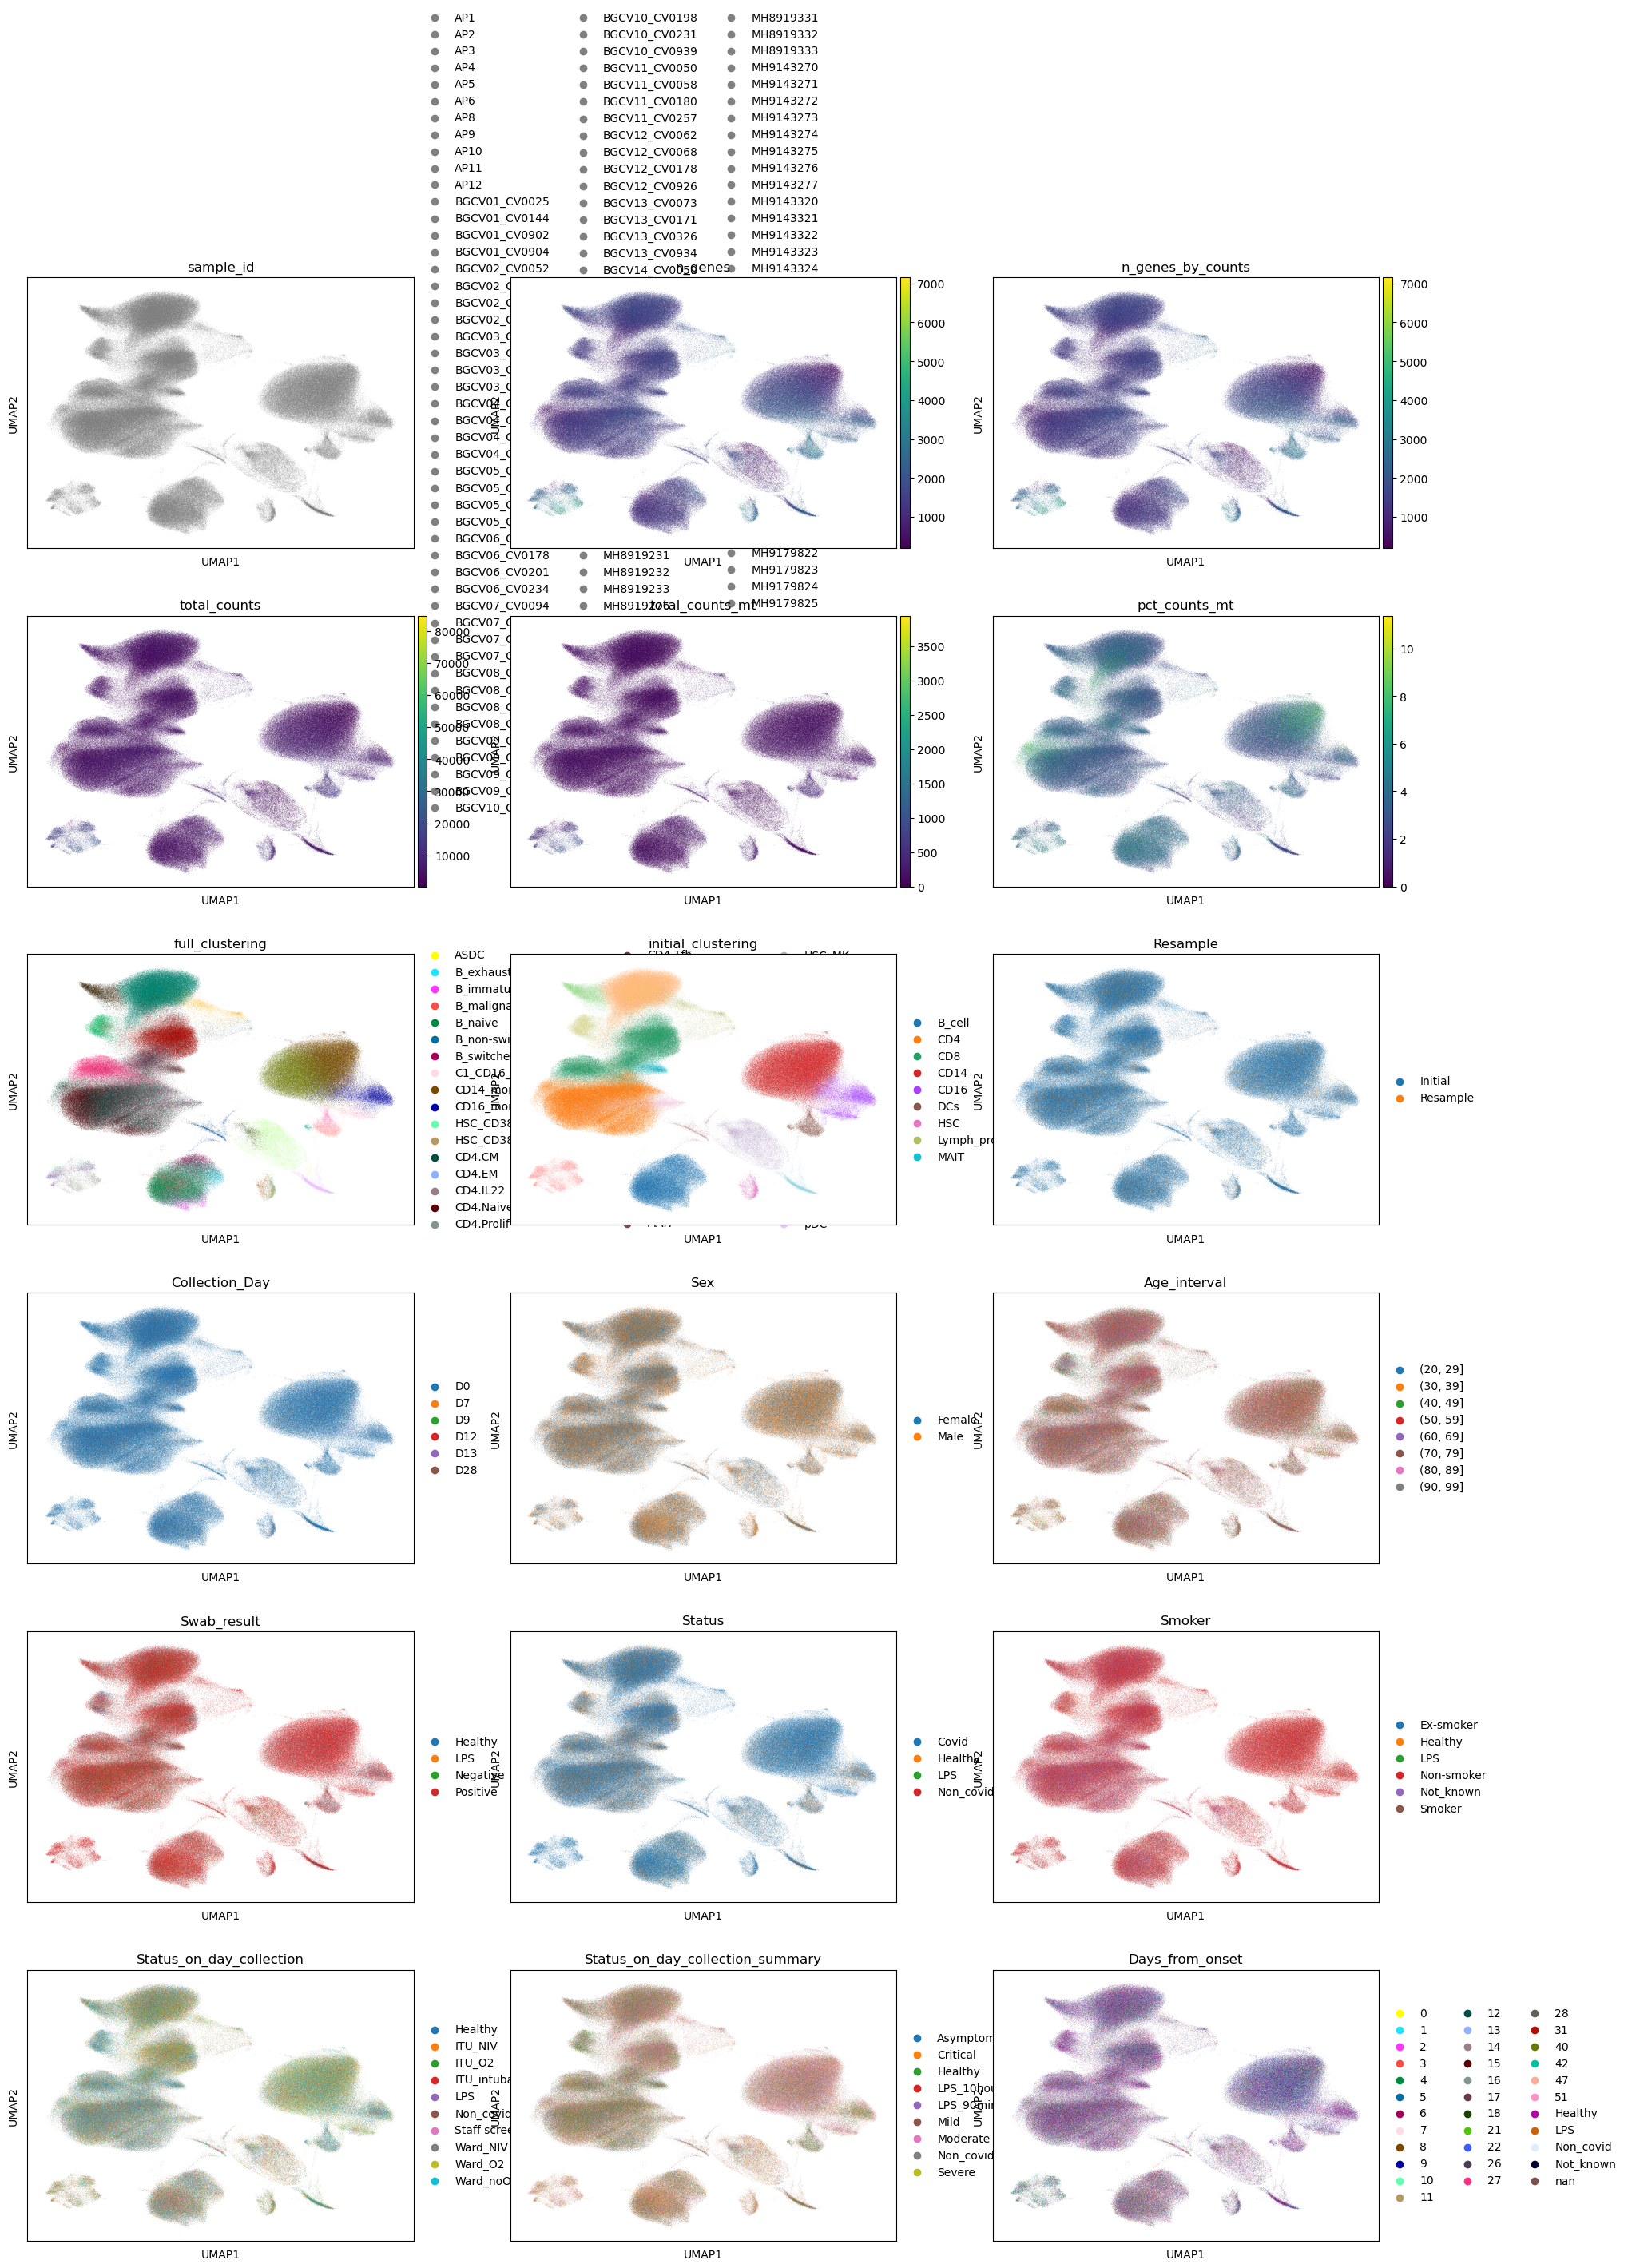

In [13]:
sc.pl.umap(adata, color=adata.obs.columns[:-5], ncols=3)

## Exploratory analysis

We want to figure out which populations change upon disease status. 

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


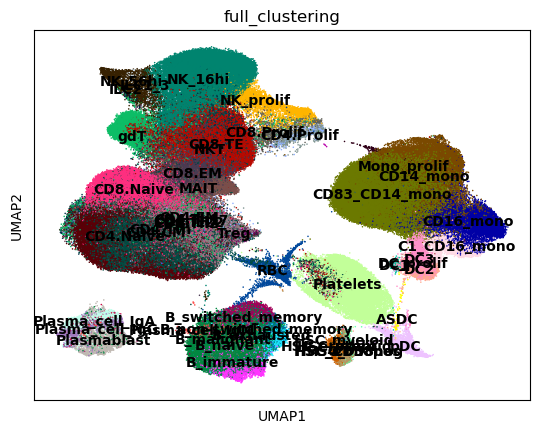

In [14]:
sc.pl.umap(adata, color='full_clustering', size=5, legend_loc='on data')

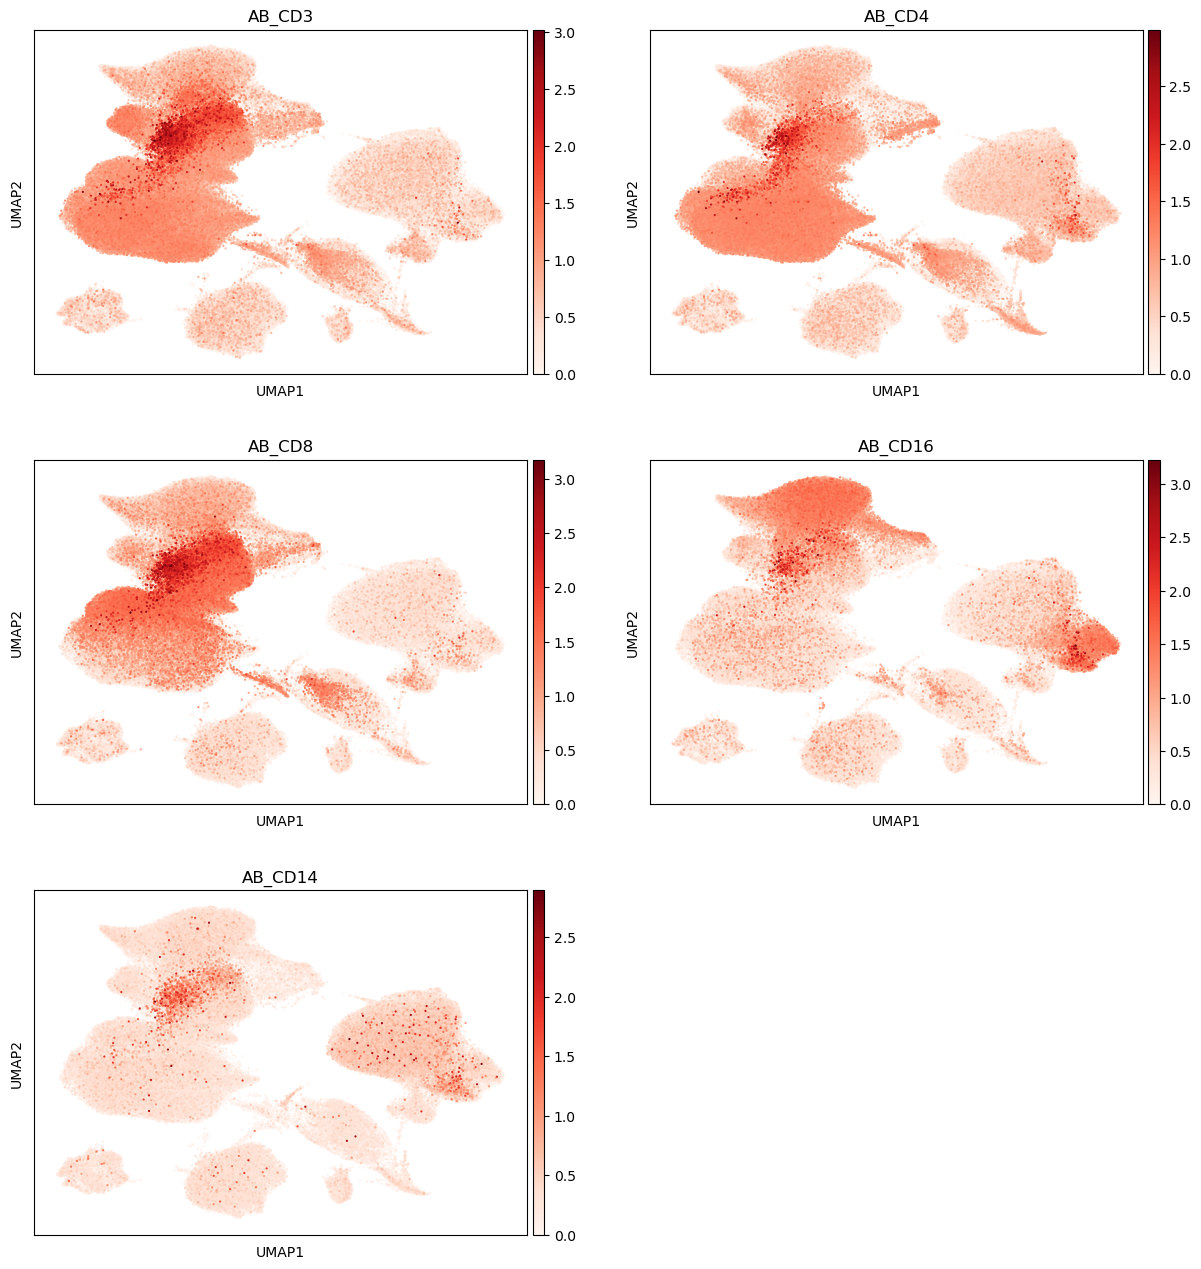

In [15]:
sc.pl.umap(adata, color=['AB_CD3', 'AB_CD4', 'AB_CD8', 'AB_CD16', 'AB_CD14'], cmap='Reds', vmin=0, ncols=2, size=10)

Let us plot the protein abundance levels per group and per cell type.

In [16]:
adata.var['feature_types']=='Antibody Capture'

MIR1302-2HG       False
AL627309.1        False
AL627309.3        False
AL627309.2        False
AL669831.2        False
                  ...  
AB_Podocalyxin     True
AB_GGT1            True
AB_c-Met           True
AB_LIGHT           True
AB_DR3             True
Name: feature_types, Length: 24929, dtype: bool

In [17]:
adata.var_names[adata.var['feature_types']=='Antibody Capture'][:50]

Index(['AB_CD80', 'AB_CD86', 'AB_CD274', 'AB_PDCD1LG2', 'AB_ICOSLG',
       'AB_ITGAM', 'AB_OX40L', 'AB_TNFSF9', 'AB_PVR', 'AB_NECTIN2', 'AB_CD47',
       'AB_CD70', 'AB_TNFRSF8', 'AB_CD40', 'AB_CD40LG', 'AB_CD52', 'AB_CD3',
       'AB_CD8', 'AB_CD56', 'AB_CD19', 'AB_CD33', 'AB_ITGAX', 'AB_CD34',
       'AB_TNFRSF17', 'AB_HLA-ABC', 'AB_THY1', 'AB_KIT', 'AB_MME', 'AB_CD45RA',
       'AB_CD123', 'AB_CD7', 'AB_ITGA6', 'AB_CCR4', 'AB_CD4', 'AB_CD44',
       'AB_CD14', 'AB_CD16', 'AB_CD25', 'AB_CD45RO', 'AB_PD1', 'AB_TIGIT',
       'AB_Mouse IgG1_K_Iso', 'AB_Mouse_IgG2a_K_Iso', 'AB_Mouse_IgG2b_K_Iso',
       'AB_Rat_IgG2b_K_Iso', 'AB_CD20', 'AB_NCR1', 'AB_PTGDR2', 'AB_EPCAM',
       'AB_PECAM1'],
      dtype='object')

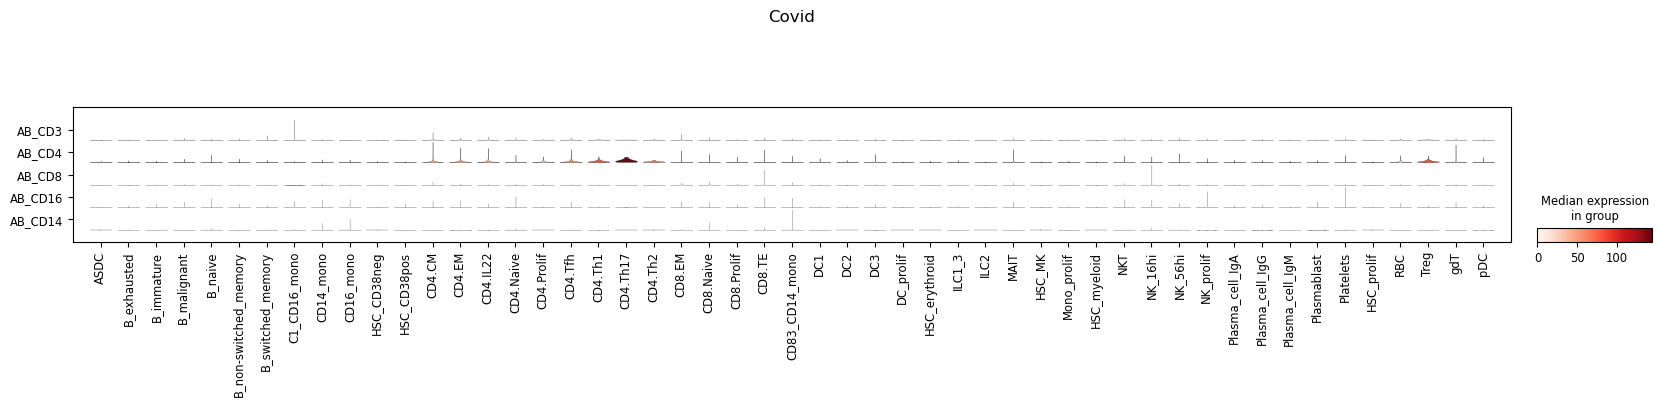

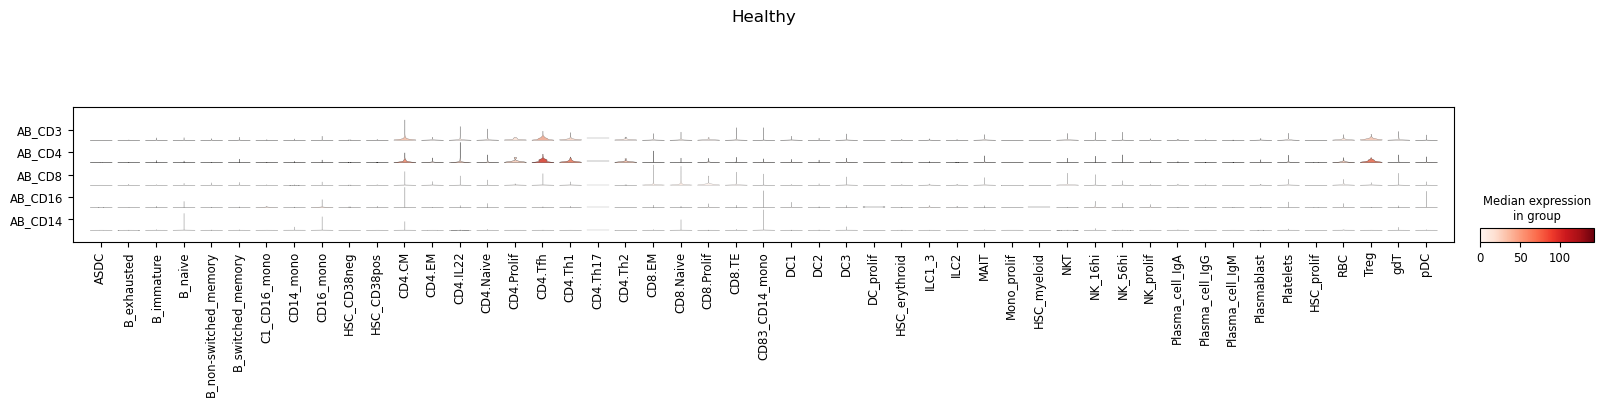

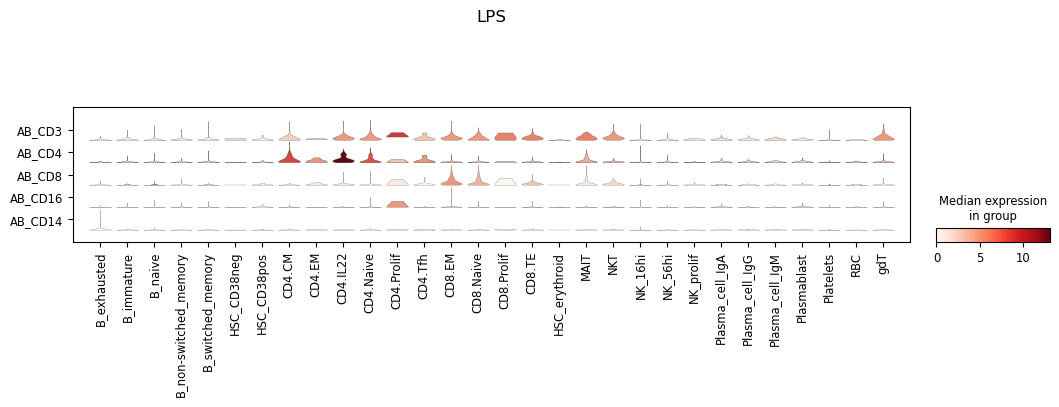

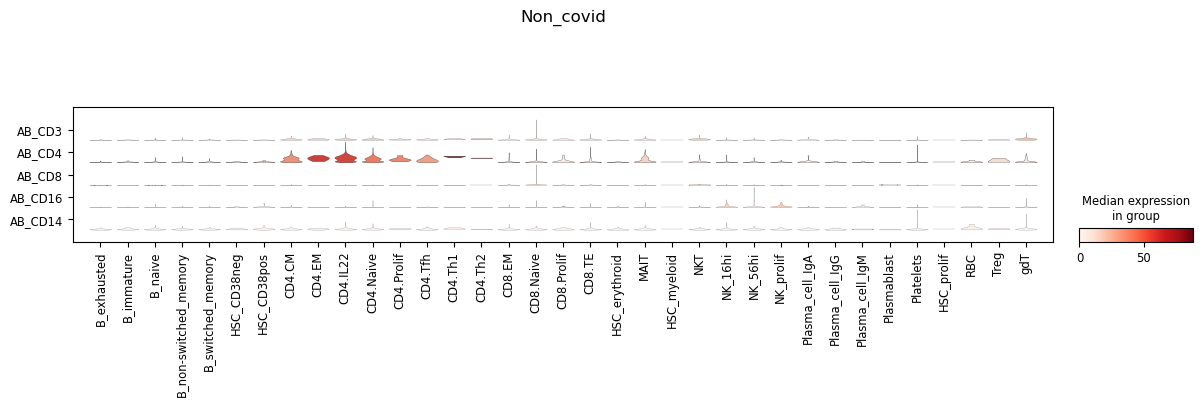

In [18]:
for status in adata.obs['Status'].cat.categories:
    adata_tmp=adata[adata.obs['Status']==status].copy()
    
    sc.pl.stacked_violin(adata_tmp, layer='raw',
                 var_names=['AB_CD3', 'AB_CD4', 'AB_CD8', 'AB_CD16', 'AB_CD14'],
                 vmin = 0, title=status, swap_axes=True,
                 cmap='Reds', groupby='full_clustering')


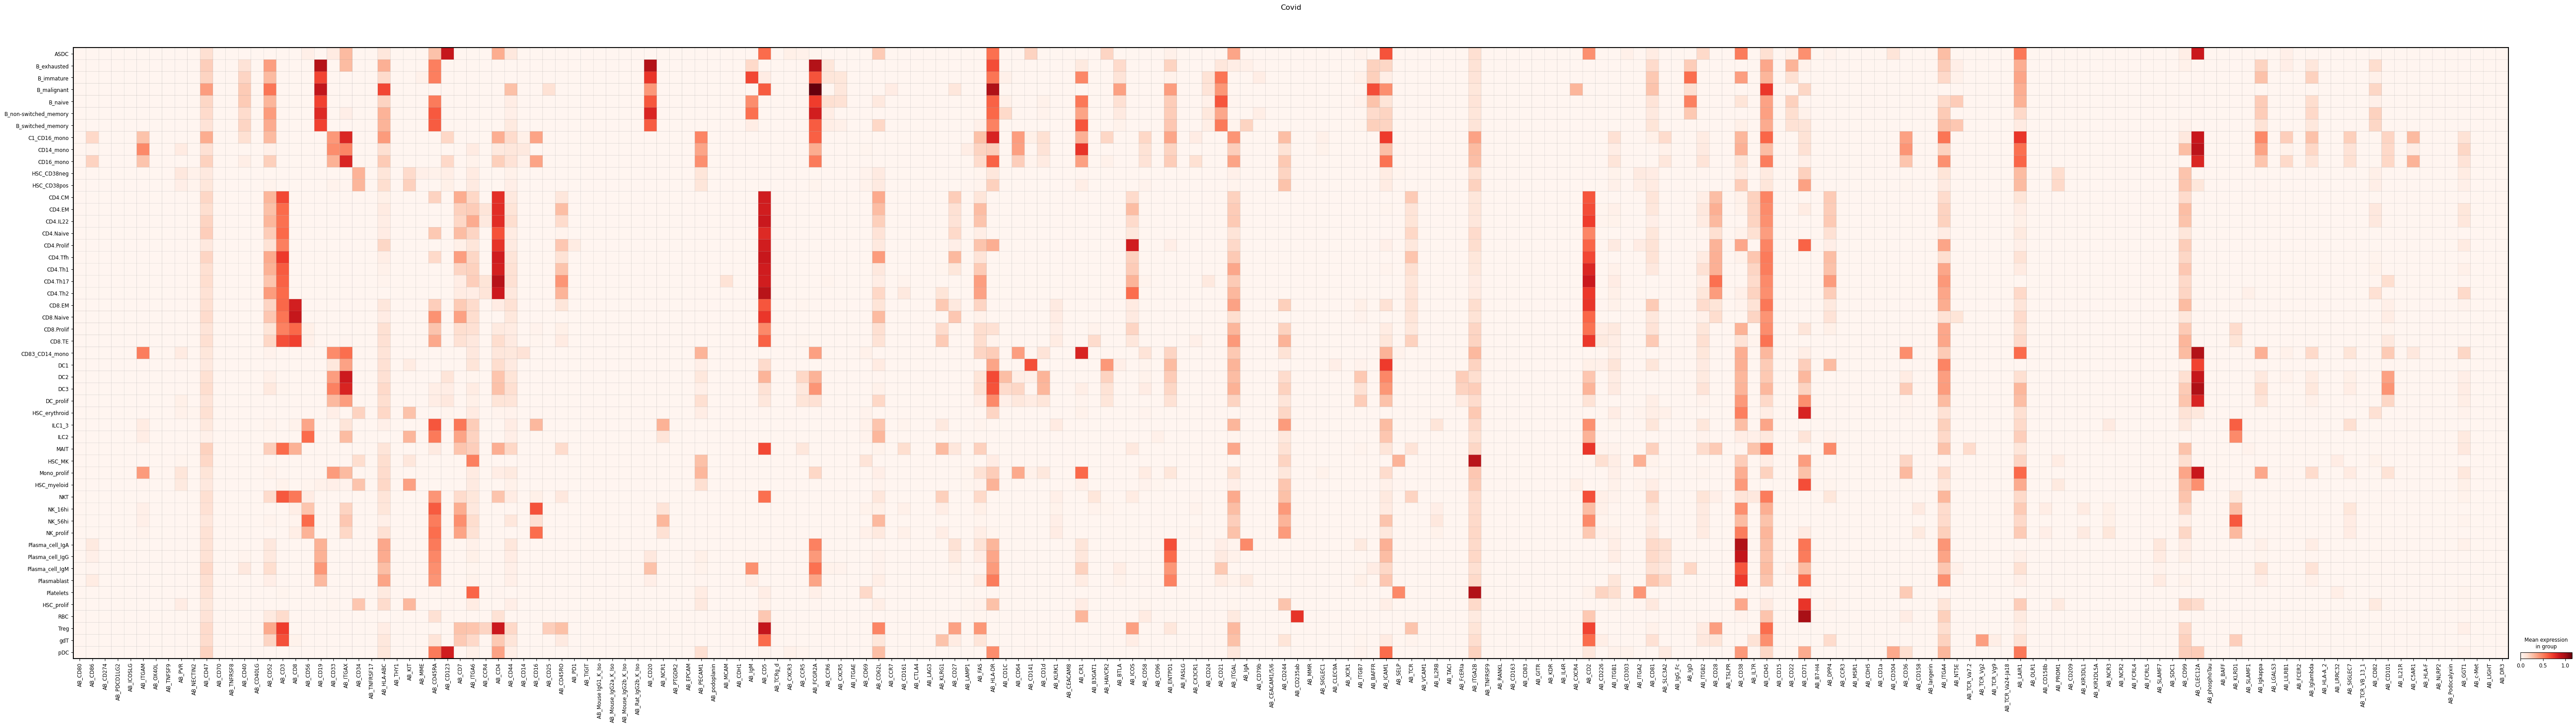

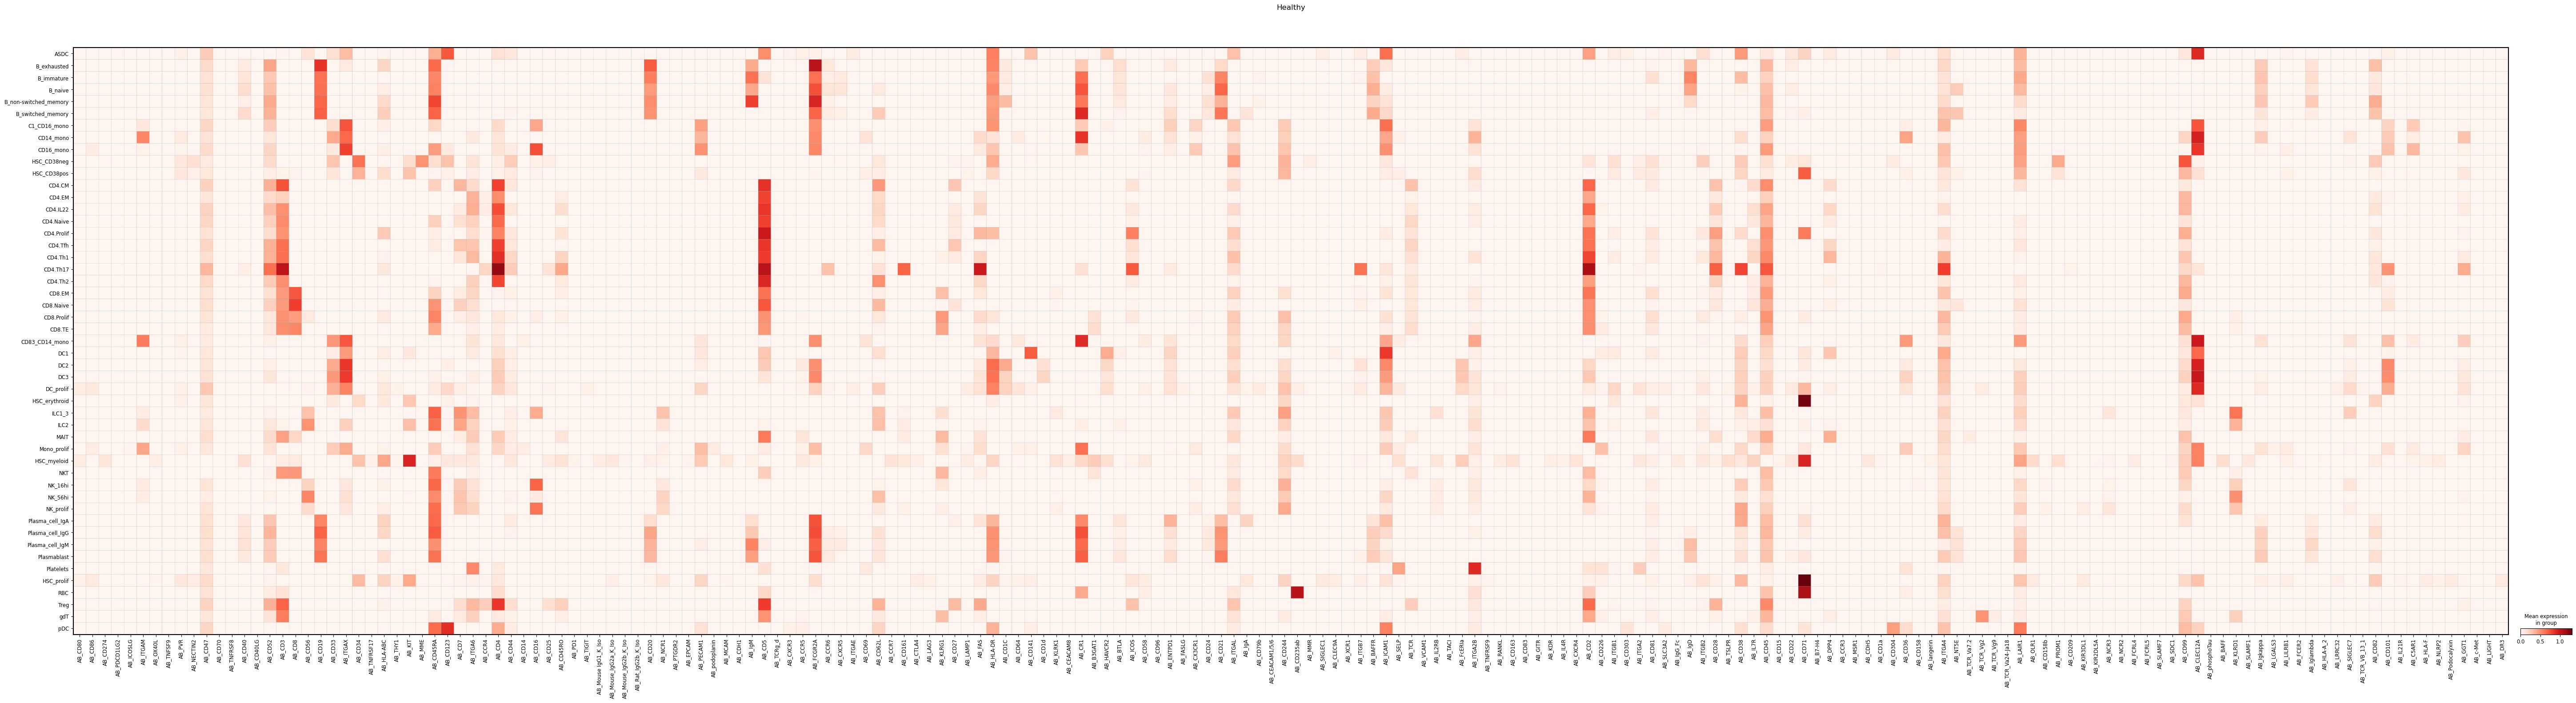

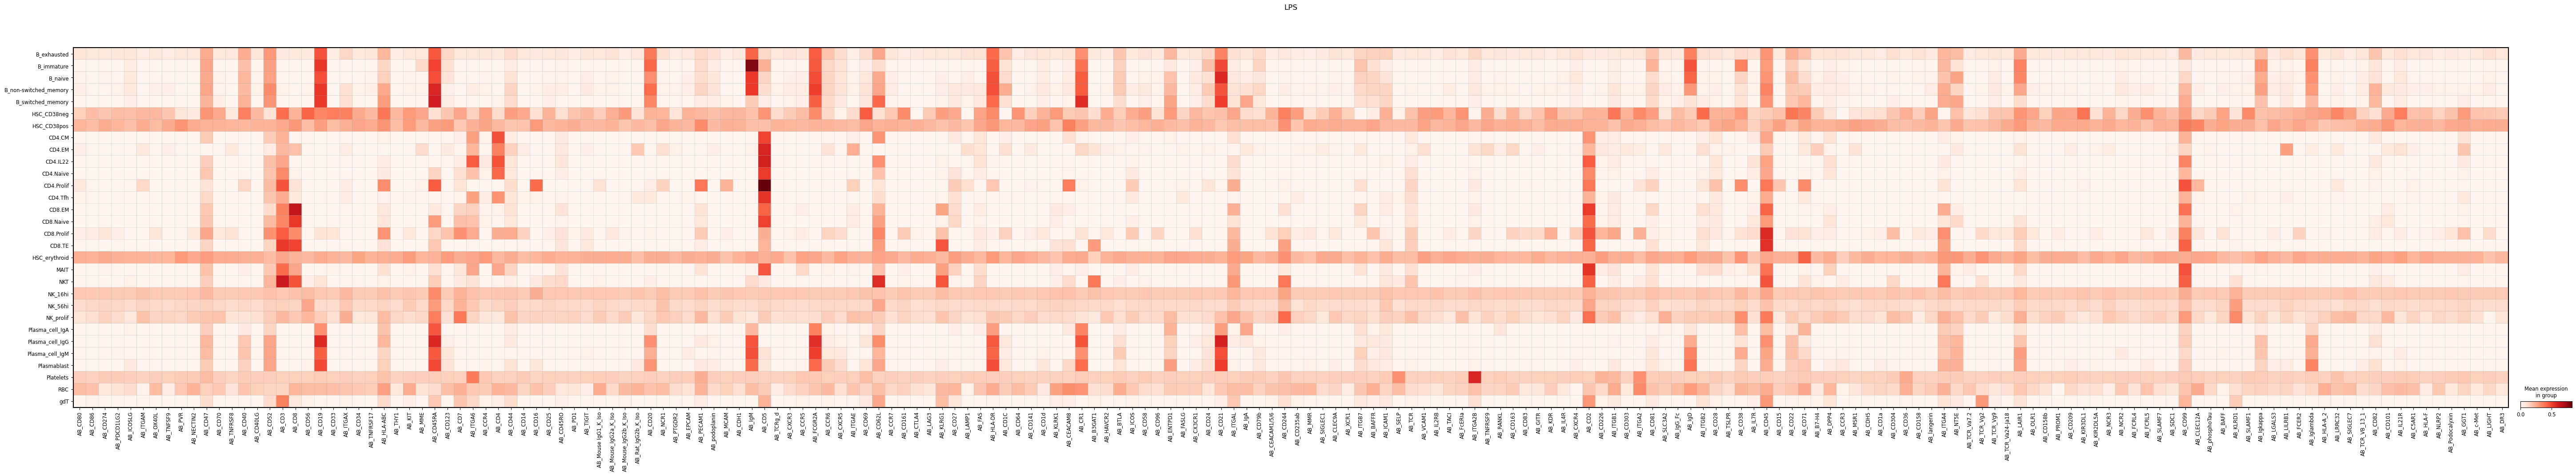

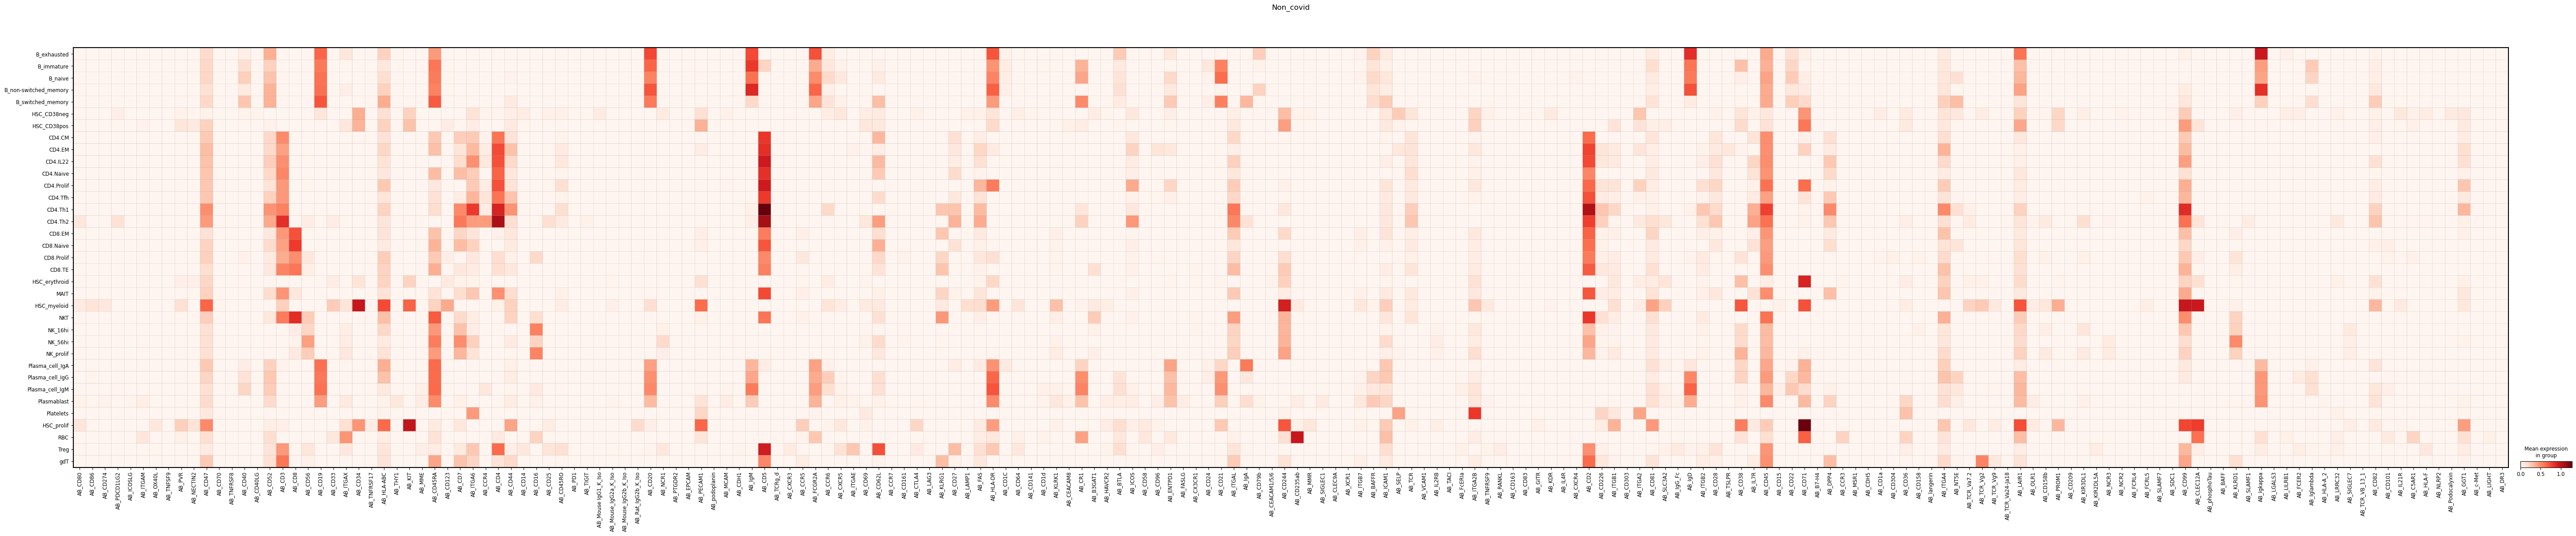

In [19]:
for status in adata.obs['Status'].cat.categories:
    adata_tmp=adata[adata.obs['Status']==status].copy()
    
    sc.pl.matrixplot(adata_tmp, 
                 var_names=adata.var_names[adata.var['feature_types']=='Antibody Capture'],
                 vmin = 0, title=status,
                 cmap='Reds', groupby='full_clustering')


We are looking for CD16+ T cells (both CD4 and CD8 compartment). 

In [20]:
cd4_comp = []
cd8_comp = []

for group in adata.obs['full_clustering'].cat.categories:
    
    if group.startswith('CD4.'):
        cd4_comp.append(group)
    elif group.startswith('CD8.'):
        cd8_comp.append(group)

In [21]:
cd8_comp

['CD8.EM', 'CD8.Naive', 'CD8.Prolif', 'CD8.TE']

In [22]:
adata_t_cell = adata[adata.obs['full_clustering'].isin(cd4_comp + cd8_comp)].copy()

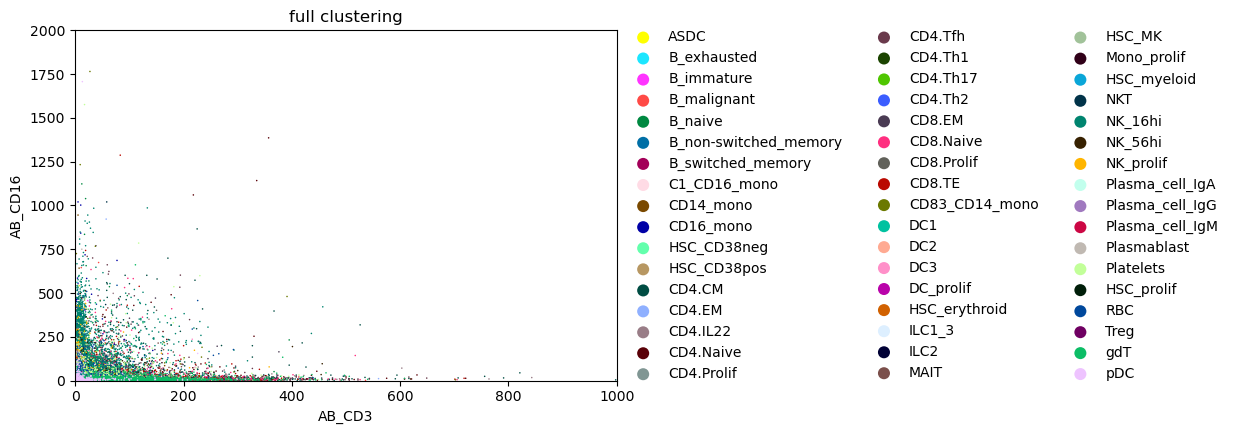

In [23]:
ax = sc.pl.scatter(adata, x='AB_CD3', y='AB_CD16', color='full_clustering', show=False, size=5, layers='raw')
ax.set_xlim([-1, 1000])
ax.set_ylim([-1, 2000])
plt.show()

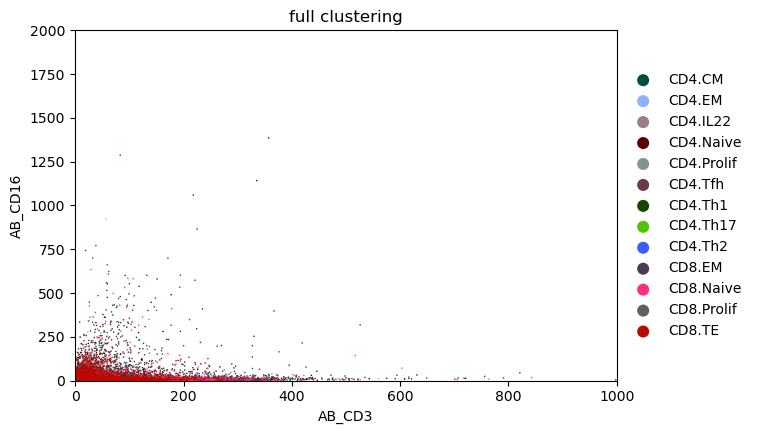

In [24]:
ax = sc.pl.scatter(adata_t_cell, x='AB_CD3', y='AB_CD16', color='full_clustering', show=False, size=5, layers='raw')
ax.set_xlim([-1, 1000])
ax.set_ylim([-1, 2000])
plt.show()

In [25]:
cd16pos_cells = adata[(adata[:, adata.var_names=='AB_CD16'].layers['raw']>200).todense()].copy()

In [26]:
cd16pos_cells.obs[['Status', 'full_clustering']].value_counts()

Status     full_clustering      
Covid      NK_16hi                  1120
Healthy    NK_16hi                   327
Covid      CD16_mono                 121
           CD4.CM                     67
           Platelets                  43
           B_naive                    38
           NK_prolif                  34
           CD4.Tfh                    25
           CD8.Naive                  23
           CD83_CD14_mono             22
           NK_56hi                    22
           C1_CD16_mono               18
Healthy    CD16_mono                  17
Covid      CD8.TE                     17
           CD4.Naive                  16
           gdT                        14
           CD8.EM                     12
           RBC                        10
Healthy    CD4.CM                     10
Covid      CD4.IL22                   10
           CD14_mono                   9
           B_immature                  8
           B_malignant                 7
Healthy    CD83_CD14_mon

In [27]:
cd16pos_tcells = adata_t_cell[(adata_t_cell[:, adata_t_cell.var_names=='AB_CD16'].layers['raw']>200).todense()].copy()

In [28]:
cd16pos_tcells.obs[['Status', 'full_clustering']].value_counts()

Status   full_clustering
Covid    CD4.CM             67
         CD4.Tfh            25
         CD8.Naive          23
         CD8.TE             17
         CD4.Naive          16
         CD8.EM             12
         CD4.IL22           10
Healthy  CD4.CM             10
         CD4.Naive           6
Covid    CD4.EM              4
Healthy  CD4.IL22            2
         CD8.EM              2
Covid    CD8.Prolif          1
Healthy  CD8.Prolif          1
         CD8.TE              1
LPS      CD8.EM              1
dtype: int64

In [30]:
adata_t_cell.obs['Status'].value_counts()

Covid        196469
Healthy       46843
Non_covid      8045
LPS            2418
Name: Status, dtype: int64

We observe more CD16+ cells in the T cell compartment of COVID-19 patients compared to the other compartments. We chose a very conservative threshold with > 200 counts for the CD16 raw antibody count, but the levels are comparable to the ones in monocytes and NK cells. 
Next, we aim to use `totalVI` to remove the background signal from the antibody tagging. 

## TotalVI integration

Our goal is to obtain a clean signal for all antibody capture markers. This will help us to rule out potential spillover from the background signal.
Using totalVI, we correct for the background signal in the antibody capture. 

Let us remove the `Non COVID19` and `LPS` stimulated cells.

In [12]:
adata = adata[adata.obs['Status'].isin(['Covid', 'Healthy'])]

In [13]:
adata.obs['Status'].value_counts()

Covid      527286
Healthy     97039
Name: Status, dtype: int64

Let us subsample adata to 100,000 cells.

In [14]:
#sc.pp.subsample(adata, n_obs=100000)

In [15]:
adata.obs['Status'].value_counts()

Covid      527286
Healthy     97039
Name: Status, dtype: int64

In [16]:
protein_adata = adata[:,adata.var['feature_types']=='Antibody Capture'].copy()

rna_adata = adata[:,adata.var['feature_types']=='Gene Expression'].copy()

Create a dense protein data matrix for now. 

In [17]:
protein_adata.X = protein_adata.layers['raw'].A.copy()

Normalize using CPM and log-scale. Overwrite the normalization of the publication.

In [18]:
rna_adata.X = rna_adata.layers['raw'].copy()
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

In [19]:
mdata = md.MuData({"rna": rna_adata, "protein": protein_adata})
mdata

MuData object with n_obs × n_vars = 624325 × 24929
  var:	'feature_types'
  2 modalities
    rna:	624325 x 24737
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types'
      uns:	'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'log1p'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    protein:	624325 x 192
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types'
      uns:	'hvg', 'leiden', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'

Compute highly variable genes and reduce gene expression data to this subset.

In [20]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=3000,
    flavor="cell_ranger",
    batch_key="sample_id",
)

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-p

In [21]:
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [22]:
mdata.update()

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


### Setup mudata for totalVI model

Now we run `setup_mudata`, which is the `MuData` analog to `setup_anndata`. The caveat of this workflow is that we need to provide this function which modality of the mdata object contains each piece of data. So for example, the batch information is in `mdata.mod["rna"].obs["batch"]`. Therefore, in the modalities argument below we specify that the `batch_key` can be found in the `"rna_subset"` modality of the `MuData` object.

Notably, we provide `protein_layer=None`. This means scvi-tools will pull information from `.X` from the modality specified in modalities ("protein" in this case). In the case of RNA, we want to use the counts, which we stored in `mdata.mod["rna"].layers["counts"]`.

In [23]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="raw",
    protein_layer=None,
    batch_key="sample_id",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

INFO     Found batches with missing protein expression                                                             


### Prepare and run model

In [24]:
vae = scvi.model.TOTALVI(mdata,override_missing_proteins=True)

INFO     Computing empirical prior initialization for protein background.                                          


In [25]:
vae.train()

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/marenbuettner/miniconda3/envs/scvi_tools/lib/p ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/marenbuettner/miniconda3/envs/scvi_tools/lib/p ...
  rank_zero_warn(


Epoch 13/13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [29:43<00:00, 135.12s/it, loss=1.17e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=13` reached.


Epoch 13/13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [29:43<00:00, 137.17s/it, loss=1.17e+03, v_num=1]


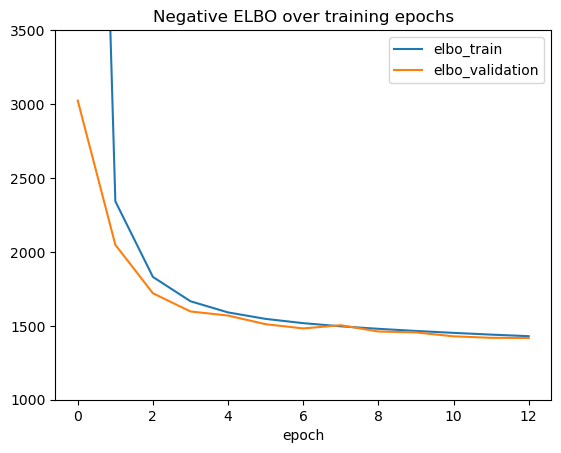

In [26]:
fig, ax = plt.subplots(1, 1)
vae.history["elbo_train"].plot(ax=ax, label="train")
vae.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", 
       ylim=(1000, 3500)
      )
ax.legend()

Save model.

In [27]:
vae.save(f'{data_dir}totalVI_model_Covid_Healthy')

Load model.

In [24]:
vae = scvi.model.TOTALVI.load(f'{data_dir}totalVI_model_Covid_Healthy/', adata=mdata)

INFO     File /home/marenbuettner/development/citeseq_integration/data/totalVI_model_Covid_Healthy/model.pt already
         downloaded                                                                                                
INFO     Found batches with missing protein expression                                                             
INFO     Found batches with missing protein expression                                                             
INFO     Computing empirical prior initialization for protein background.                                          


### Analyze outputs

We use Scanpy and muon for clustering and visualization after running totalVI. 

In [25]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]

# arbitrarily store latent in rna modality
rna.obsm["X_totalVI"] = vae.get_latent_representation()

Split the index range into several batches of size 100,000.

In [31]:
chunk_size = 10000
n_full_chunks = rna.n_obs // chunk_size
rem_chunk_size = rna.n_obs % chunk_size

if n_full_chunks > 0:
    index_ranges = np.arange(n_full_chunks + 1) * chunk_size
    if rem_chunk_size > 0:
        full_ranges = np.concatenate([index_ranges, np.array([rna.n_obs])]) 
    else:
        full_ranges = index_ranges    
else:
    full_ranges = np.arange(0, 2) * rem_chunk_size

In [33]:
#run in several batches to lower cpu and memory load
rna_list = []
protein_list = []
for idx in range(1, len(full_ranges)):
    print(idx)
    rna_denoised, protein_denoised = vae.get_normalized_expression(adata=mdata, 
                            indices=range(full_ranges[idx-1], full_ranges[idx]), #use only subset if kernel dies
        n_samples=25, return_mean=True, transform_batch=None, 
    )
    rna_list.append(rna_denoised)
    protein_list.append(protein_denoised)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [36]:
rna_denoised_all = pd.concat(rna_list)

In [39]:
protein_denoised_all = pd.concat(protein_list)

In [40]:
(
    rna.layers["denoised_rna"],
    protein.layers["denoised_protein"],
) = (rna_denoised_all, protein_denoised_all)

In [41]:
protein.layers["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, return_mean=True, transform_batch=None
)
#parsed_protein_names = [p.split("_")[1] for p in protein.var_names]
#protein.var["clean_names"] = parsed_protein_names
mdata.update()

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Now we can compute clusters and visualize the latent space.

In [42]:
sc.pp.neighbors(rna, use_rep="X_totalVI")
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="leiden_totalVI")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [43]:
mdata.update()

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [55]:
mdata['rna'].var_names

Index(['MIR1302-2HG', 'AL627309.1', 'AL627309.3', 'AL627309.2', 'AL669831.2',
       'FAM87B', 'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11',
       ...
       'MAFIP', 'AC011043.1', 'AL592183.1', 'AC007325.1', 'AC007325.4',
       'AC007325.2', 'AL354822.1', 'AC233755.2', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=24737)

In [56]:
mdata['rna_subset'].var_names

Index(['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'MMP23B', 'MEGF6',
       'SMIM1', 'TNFRSF25', 'UTS2',
       ...
       'ITGB2-AS1', 'ADARB1', 'COL6A2', 'C21orf58', 'PCNT', 'DIP2A', 'S100B',
       'MT-ND6', 'AC233755.2', 'AC233755.1'],
      dtype='object', length=3000)

In [66]:
mdata.var

rna:highly_variable  rna:means  rna:dispersions  \
rna:MIR1302-2HG                     False   0.000019         0.101665   
rna:AL627309.1                      False   0.000955         1.215834   
rna:AL627309.3                      False   0.000029         0.078177   
rna:AL627309.2                      False   0.000021         0.116756   
rna:AL669831.2                      False   0.000008         0.057654   
...                                   ...        ...              ...   
rna_subset:DIP2A                      NaN        NaN              NaN   
rna_subset:S100B                      NaN        NaN              NaN   
rna_subset:MT-ND6                     NaN        NaN              NaN   
rna_subset:AC233755.2                 NaN        NaN              NaN   
rna_subset:AC233755.1                 NaN        NaN              NaN   

                       rna:dispersions_norm  rna:highly_variable_nbatches  \
rna:MIR1302-2HG                    0.012935                           2.0   
rna:AL627309.1                     0.405576                          30.0   
rna:AL627309.3                     0.000045                           2.0   
rna:AL627309.2                     0.047879                           3.0   
rna:AL669831.2                     0.017595                           1.0   
...                                     ...                           ...   
rna_subset:DIP2A                        NaN                           NaN   
rna_subset:S100B                        NaN                           NaN   
rna_subset:MT-ND6                       NaN                           NaN   
rna_subset:AC233755.2                   NaN                           NaN   
rna_subset:AC233755.1                   NaN                           NaN   

                      rna:highly_variable_intersection  \
rna:MIR1302-2HG                                  False   
rna:AL627309.1                                   False   
rna:AL627309.3                                   False   
rna:AL627309.2                                   False   
rna:AL669831.2                                   False   
...                                                ...   
rna_subset:DIP2A                                   NaN   
rna_subset:S100B                                   NaN   
rna_subset:MT-ND6                                  NaN   
rna_subset:AC233755.2                              NaN   
rna_subset:AC233755.1                              NaN   

                      rna_subset:highly_variable  rna_subset:means  \
rna:MIR1302-2HG                              NaN               NaN   
rna:AL627309.1                               NaN               NaN   
rna:AL627309.3                               NaN               NaN   
rna:AL627309.2                               NaN               NaN   
rna:AL669831.2                               NaN               NaN   
...                                          ...               ...   
rna_subset:DIP2A                            True          0.235172   
rna_subset:S100B                            True          0.068848   
rna_subset:MT-ND6                           True          0.624983   
rna_subset:AC233755.2                       True          0.008087   
rna_subset:AC233755.1                       True          0.008138   

                       rna_subset:dispersions  rna_subset:dispersions_norm  \
rna:MIR1302-2HG                           NaN                          NaN   
rna:AL627309.1                            NaN                          NaN   
rna:AL627309.3                            NaN                          NaN   
rna:AL627309.2                            NaN                          NaN   
rna:AL669831.2                            NaN                          NaN   
...                                       ...                          ...   
rna_subset:DIP2A                     1.324711                     2.037833   
rna_subset:S100B                     2.019900             

#### Visualize results

For data visualization, we use the muon package in the next notebook.

In [61]:
mdata.write(f'{data_dir}haniffa21_totalVI_Covid_Healthy.h5mu')

/home/marenbuettner/miniconda3/envs/scvi_tools/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
